In [1]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, LeaveOneLabelOut
from glob import glob
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def array_to_epochs(record, epoch_length, start):
    """Separate the different epochs from the array"""
    n_epochs = len(record[start:])//epoch_length
    new = np.zeros((n_epochs, 8, epoch_length))
    for j in range(start,n_epochs*epoch_length+start):
        for c in range(8):
            epoch_id = (j - start)//epoch_length
            s_id = (j - start)%epoch_length
            try:
                new[epoch_id][c][s_id] = float(str(record[j][c]).replace(',','.'))
            except IndexError:
                print(str(j) +' '+ str(c) +' ' + str(epoch_id) + ' ' + str(s_id))
    return new


def record_to_array(record):
    """Transform python record structure to numpy array"""
    new = np.zeros((len(record), 8))
    for i in range(len(record)):
        for j in range(1,9):
            new[i][j-1] = float(str(record[i][j]).replace(',','.'))
    return new

def preprocess_data(fname, data_type):
    """From a file, extract the different epochs and bandpass them to keep only 7-35 Hz frequencies. Return epochs and labels
    for each epoch"""
    data = np.recfromcsv(fname, delimiter=', ', skip_header=5) #Get record from file
    data = record_to_array(data)
    data = butter_bandpass_filter(data, 7, 35, 250, order=5) #Bandpass filter to keep 7-35 HZ frequencies
    data = array_to_epochs(data, 500, 500) #Epoch array with 2s epochs (500 samples), and reject the 500 first samples
    #Label = 0 if right movement, 1 if left movement
    if data_type == 'right':
        labels = np.zeros((len(data),)) 
    else:
        labels = np.ones((len(data),))
    return data, labels

In [3]:
from scipy.signal import butter, lfilter, iirfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    """Return filter coeffs for a bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Appply bandpass filter to an array"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=5)
    out = lfilter(b, a, data, axis = 0)
    return out

In [4]:
#Files names
subject1 = 'martin'
fname_right = '{0}_data/OpenBCI-RAW-{0}-droite-ouvert.txt'.format(subject1)
fname_left = '{0}_data/OpenBCI-RAW-{0}-gauche-ouvert.txt'.format(subject1)

subject2 = 'lad'
test_right = '{0}_data/OpenBCI-RAW-{0}-droite-ouvert.txt'.format(subject2)
test_left = '{0}_data/OpenBCI-RAW-{0}-gauche-ouvert.txt'.format(subject2)

timedif_right = 'martin_data/OpenBCI-RAW-martin-droite-2.txt'
timedif_left = 'martin_data/OpenBCI-RAW-martin-gauche-2.txt'

AUC = 0.941176470588


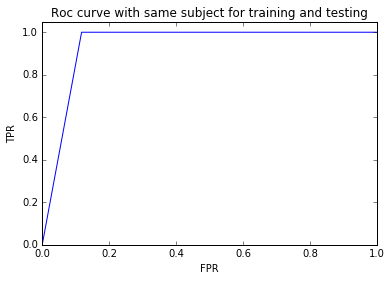

In [32]:
%matplotlib inline
########################## Compute ROC curve for same suject for training and testing ###########################################
data_right, labels_right = preprocess_data(fname_right, 'right')
data_left, labels_left = preprocess_data(fname_left, 'left')

#80% data for training, 20% for testing
ratio = 0.8
#Separate training and test data
training_data = np.concatenate((data_right[:int(ratio*len(data_right))], data_left[:int(ratio*len(data_left))]), axis=0)
training_labels = np.concatenate((labels_right[:int(ratio*len(labels_right))], 
                                 labels_left[:int(ratio*len(labels_left))]), axis=0)
test_data = np.concatenate((data_right[int(ratio*len(data_right)):], data_left[int(ratio*len(data_left)):]), axis=0)
test_labels = np.concatenate((labels_right[int(ratio*len(labels_right)):], 
                             labels_left[int(ratio*len(labels_left)):]), axis=0)
#Fit CSP filter with training data
csp = CSP(reg='ledoit_wolf')
csp.fit(np.ndarray(shape=training_data.shape, buffer=training_data), training_labels)

#Filter training and test data with CSP
filtered_training = csp.transform(training_data)
filtered_test = csp.transform(test_data)

#Shuffle train and test data
train_data, train_labels = shuffle(filtered_training, training_labels, random_state=42)
test_d, test_l = shuffle(filtered_test, test_labels, random_state=25)

#Train classifier
clf = LogisticRegression()
clf.fit(train_data, train_labels)

#Predict labels from test data
output = clf.predict(test_d)

#Plot ROC curve and print AUC
fpr, tpr, th = roc_curve(test_l, output)
roc_auc = auc(fpr, tpr)
print('AUC = ' + str(roc_auc))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1.05])
plt.title('Roc curve with same subject for training and testing')
plt.show()

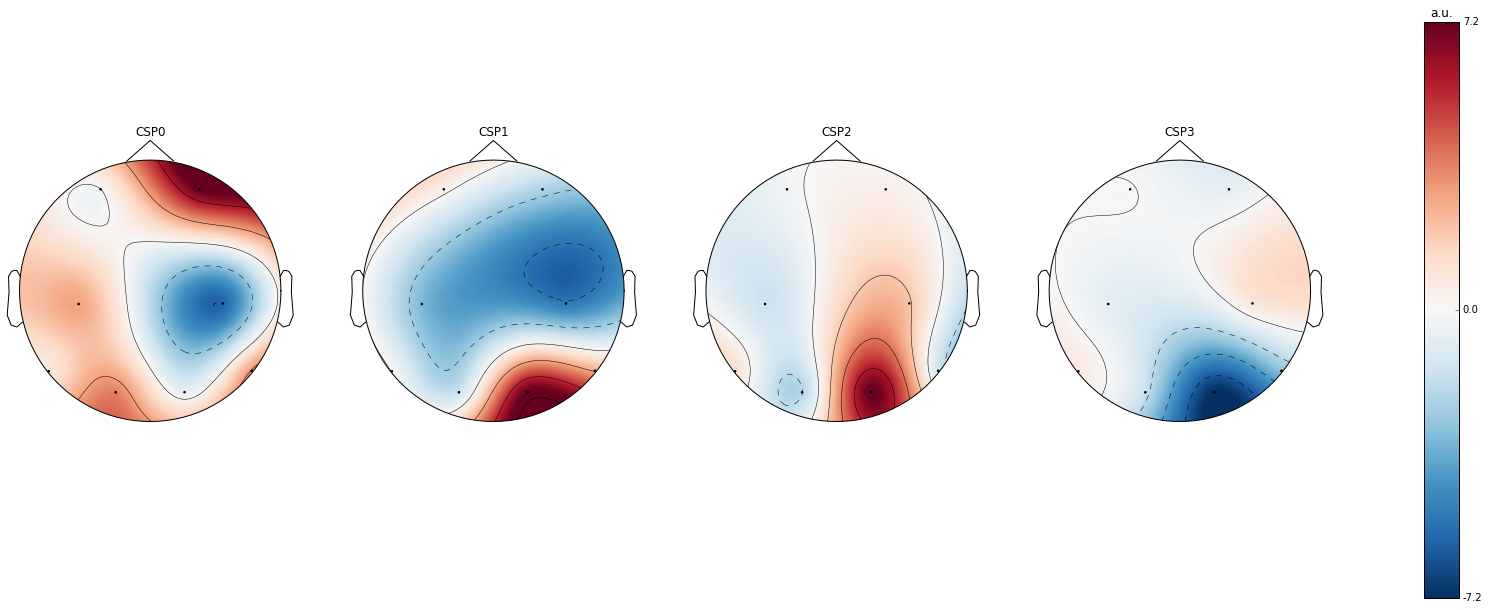

In [26]:
%matplotlib inline
#################################################### Display CSP filters ########################################################
bads = []
ch_names = ['Fp1','Fp2','C3','C4','P7','P8','O1','O2']
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
montage = read_montage('standard_1020', ch_names)
fs = 250
info = create_info(ch_names, fs, ch_types, montage)

f = csp.plot_filters(info, show=False)
f.set_figheight(16)
f.set_figwidth(24)

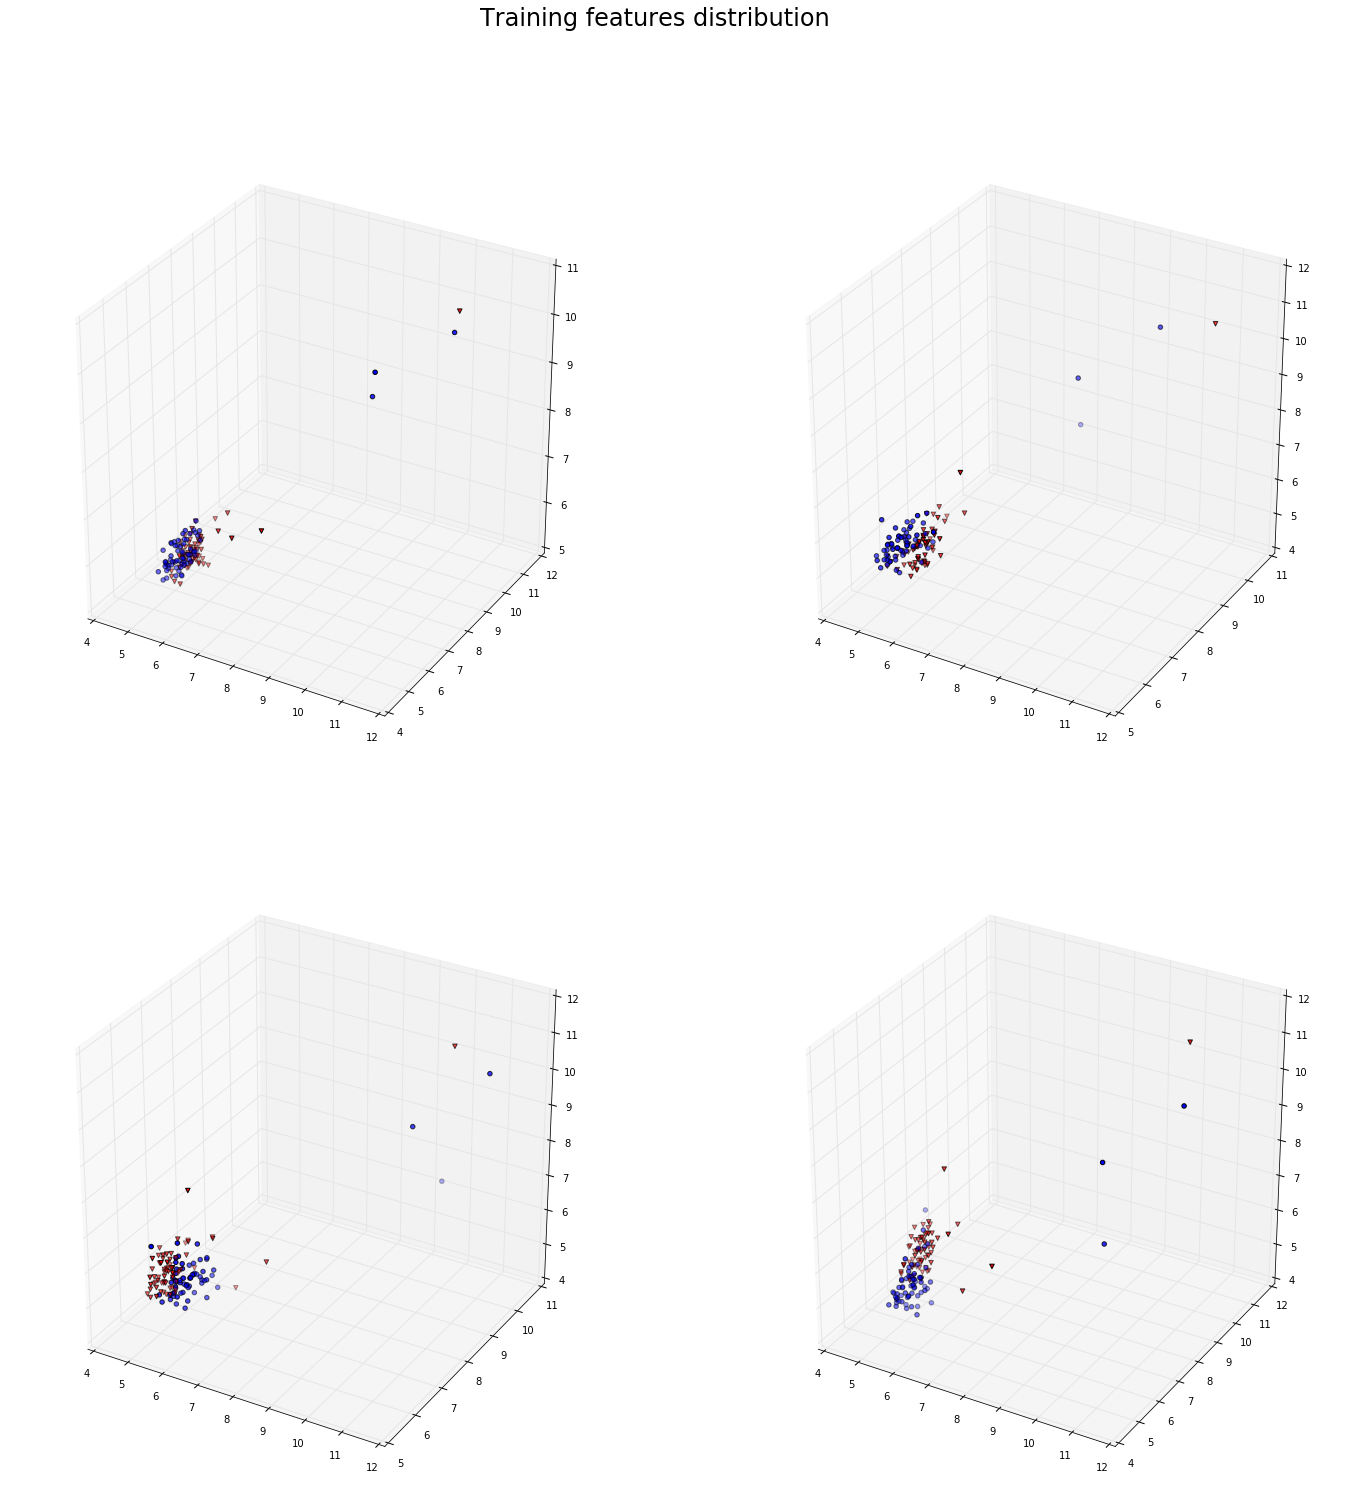

In [29]:
####################################### Display training features distribution ##################################################
fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(24)
combs = [[0,1,2],[1,2,3],[0,2,3],[0,1,3]]

lenf = len(filtered_training)
right = filtered_training[:lenf//2]
left = filtered_training[lenf//2:]
sorted_feat = [right, left]
colors = 'br'
markers = 'ov'
for c in range(len(combs)):
    ax = fig.add_subplot(2,2,c+1, projection='3d')
    for k in range(2):
        f = sorted_feat[k]
        ax.scatter(f[:,combs[c][0]], f[:,combs[c][1]], f[:,combs[c][2]], c=colors[k], marker = markers[k])
fig.suptitle('Training features distribution', fontsize=24)
plt.show()

AUC = 0.5


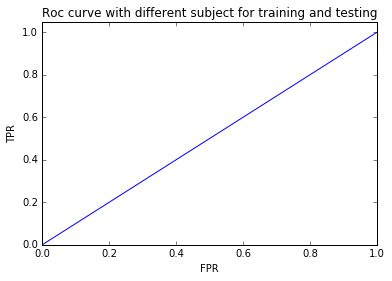

In [31]:
#Subject different for training and test

#Get training data from subject 1
data_right, labels_right = preprocess_data(fname_right, 'right')
data_left, labels_left = preprocess_data(fname_left, 'left')

training_data = np.concatenate((data_right, data_left), axis=0)
training_labels = np.concatenate((labels_right, labels_left), axis=0)

#Get test data from subject 2
test_data_right, test_labels_right = preprocess_data(test_right, 'right')
test_data_left, test_labels_left = preprocess_data(test_left, 'left')

test_data = np.concatenate((test_data_right, test_data_left), axis=0)
test_labels = np.concatenate((test_labels_right, test_labels_left), axis=0)

#Fit CSP with training data
csp = CSP(reg='ledoit_wolf')
csp.fit(np.ndarray(shape=training_data.shape, buffer=training_data), training_labels)

#Apply CSP to training and test data
filtered_training = csp.transform(training_data)
filtered_test = csp.transform(test_data)

#Shuffle training and test data
train_data, train_labels = shuffle(filtered_training, training_labels, random_state=42)
test_d, test_l = shuffle(filtered_test, test_labels, random_state=25)

#Fit classifier
clf = LogisticRegression()
clf.fit(train_data, train_labels)

#Predict labels from test data
output = clf.predict(test_d)

#Plot ROC curve and print AUC
fpr, tpr, th = roc_curve(test_l, output)
roc_auc = auc(fpr, tpr)
print('AUC = ' + str(roc_auc))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1.05])
plt.title('Roc curve with different subject for training and testing')
plt.show()